In [3]:
import pandas as pd
from fastai.vision.all import *

MANIFESTS_DIR = os.path.join(os.path.dirname(os.path.abspath('')), 'floripa-guessr', 'dataset', 'manifests')
TRAIN_CSV = os.path.join(MANIFESTS_DIR, "training_manifest.csv")
VALID_CSV = os.path.join(MANIFESTS_DIR, "validation_manifest.csv")

BATCH_SIZE = 64
IMG_CROP_SIZE = 512
NUM_WORKERS = 16

IMG_CROP_SIZE, BATCH_SIZE, MANIFESTS_DIR, TRAIN_CSV, VALID_CSV

(512,
 64,
 '/lapix/floripa-guessr/dataset/manifests',
 '/lapix/floripa-guessr/dataset/manifests/training_manifest.csv',
 '/lapix/floripa-guessr/dataset/manifests/validation_manifest.csv')

In [26]:

#### build_datablock():
training_dataframe = pd.read_csv(TRAIN_CSV)
validation_dataframe = pd.read_csv(VALID_CSV)

# setup for datablock splitter
training_dataframe['is_validation'] = False
validation_dataframe['is_validation'] = True

dataframe = pd.concat([training_dataframe, validation_dataframe])

print(f"Dataframe shape: {dataframe.shape}")
print(f"Sample files exist: {dataframe['file'].head().apply(os.path.exists).all()}")
print(f"Unique cells: {dataframe['cell'].nunique()}")

class_counts = training_dataframe['cell'].value_counts()
print(f"Most common class: {class_counts.iloc[0]} samples")
print(f"Least common class: {class_counts.iloc[-1]} samples")
print(f"Class imbalance ratio: {class_counts.iloc[0] / class_counts.iloc[-1]:.2f}")

transforms = [
    *aug_transforms(
        size=IMG_CROP_SIZE,
        flip_vert=False,
        max_rotate=15.,
        max_zoom=1.05,
        max_lighting=0.3,
        max_warp=0.,
        p_affine=0.7,
        p_lighting=0.6
    ),
    Normalize.from_stats(*imagenet_stats)
]

datablock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader('file'),
    get_y=ColReader('cell'),
    splitter=ColSplitter('is_validation'),
    item_tfms=Resize(IMG_CROP_SIZE, method='squish'),
    batch_tfms=transforms
)

Dataframe shape: (10371, 7)
Sample files exist: True
Unique cells: 30
Most common class: 557 samples
Least common class: 70 samples
Class imbalance ratio: 7.96


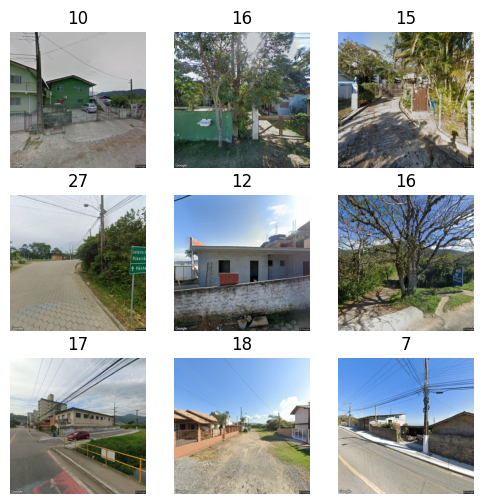

In [27]:
### build_dataloader(datablock, dataframe):
dataloaders = datablock.dataloaders(
    dataframe,
    bs=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle_train=True
)

dataloaders.valid.show_batch(max_n=9, figsize=(6,6))

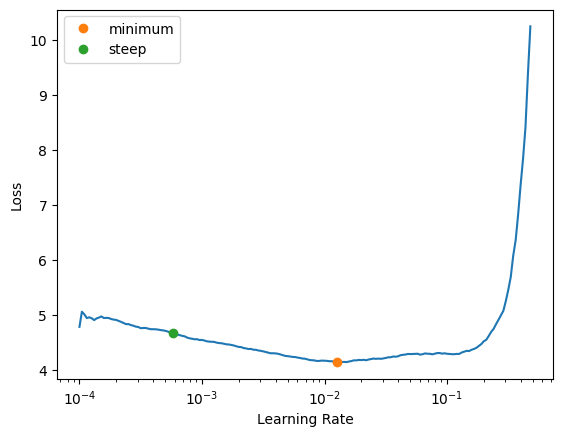

In [39]:
### build_learner(dataloaders):
learner = vision_learner(
    dataloaders,
    efficientnet_b4,
    metrics=[accuracy, partial(top_k_accuracy, k=3), partial(top_k_accuracy, k=5)],
)

lr_min, lr_steep = learner.lr_find(
    start_lr=1e-4,
    end_lr=1,
    num_it=200,
    stop_div=True,
    show_plot=True,
    suggest_funcs=(minimum, steep)
)
# empirically best learning rate
#lr_min, lr_steep = 0.002290867641568184, 0.002290867641568184
print(lr_min, lr_steep)

In [ ]:
### train_learner(learner, lr_min, lr_steep):
print("Starting training...")
print("1) training classifier head...\n")
learner.freeze()
learner.fit_one_cycle(
    3, 
    lr_max=lr_steep,
    cbs=[SaveModelCallback(monitor='valid_loss')]
)

print("2) fine-tuning entire model...\n")
learner.unfreeze()
learner.fit_one_cycle(
    8, 
    lr_max=slice(lr_steep/10, lr_steep/3),
    cbs=[
        SaveModelCallback(monitor='valid_loss'),
        EarlyStoppingCallback(monitor='valid_loss', patience=3)
    ]
)

print("3) fine-tune with lower learning rate and higher weight decay")
learner.fit_one_cycle(
    4,
    slice(lr_steep/100, lr_steep/10),
    wd=0.1
)

Starting training...
1) training classifier head...



epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,time
0,4.208819,3.090986,0.147470,0.327711,0.446265,00:51
1,3.667572,2.894033,0.199036,0.395663,0.514217,00:52


Better model found at epoch 0 with valid_loss value: 3.0909857749938965.
Better model found at epoch 1 with valid_loss value: 2.894033432006836.


In [ ]:
### show_results(learner):
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(figsize=(12, 10), dpi=100)
interp.plot_top_losses(16, nrows=4, figsize=(16, 12))

most_confused = interp.most_confused(min_val=3)
print("Most Confused Classes:")
for confusion in most_confused:
    print(f"  {confusion[0]} ↔ {confusion[1]}: {confusion[2]} misclassifications")

class_accuracies = {}
preds, targets = learner.get_preds()
pred_classes = preds.argmax(dim=1)

for i, class_name in enumerate(learner.dls.vocab):
    mask = targets == i
    if mask.sum() > 0:
        acc = (pred_classes[mask] == i).float().mean()
        class_accuracies[class_name] = acc.item()

print("\nPer-Class Accuracies:")
sorted_accs = sorted(class_accuracies.items(), key=lambda x: x[1])
for class_name, acc in sorted_accs:
    print(f"  {class_name}: {acc:.3f}")

### execute_pipeline():
# dataframe, datablock = build_datablock()
# dataloaders = build_dataloader(datablock, dataframe)
# model, lr_min, lr_steep = build_learner(dataloaders)
# train_learner(model, lr_min, lr_steep)
# show_results(model)

model_out = "floripa-guessr.pkl"
learner.export(model_out)
print(f"Model exported to {model_out}")